## 참고 글
- [크롬 개발자 도구 Console에서 Google Play Review 크롤링하기](https://zzsza.github.io/development/2019/03/12/crawling-in-developer-tools-console/)
- 크롤링한 review.json 업로드 필요

## 필요 라이브러리 설치
- konlpy

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy wordcloud

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InR

## 폰트 설치

In [ ]:
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 40 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-eco all 1.000-6 [14.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-extra all 20170925-1 [12.2 MB]
Get:4 http://archive.ubu

In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import json
import re
from bs4 import BeautifulSoup
import warnings
import numpy as np
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###닥터나우

In [ ]:
df = pd.read_json("/content/drive/MyDrive/puzzleAI/스토어 앱리뷰 분석/doctor_now_gp_review.json")

In [ ]:
df.head(3)

,body
0,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."
1,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."
2,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."


In [ ]:
p = re.compile(r'\d+')
def parser(body):
    bs = BeautifulSoup(body, 'html.parser')
    user_name = bs.find('span', class_='X43Kjb').text
    date = bs.find('span', class_='p2TkOb').text
    rating = bs.find('div', {'role':'img'})['aria-label']
    rating = p.findall(rating)[-1]
    review_text = bs.find('span', {'jsname':'bN97Pc'}).text
    return user_name, date, rating, review_text

In [ ]:
%%time
df['user_name'], df['date'], df['rating'], df['review_text'] = zip(*df['body'].map(parser))

CPU times: user 1.31 s, sys: 4.14 ms, total: 1.31 s
Wall time: 1.33 s


In [ ]:
del df["body"]

In [ ]:
df.head(3)

,user_name,date,rating,review_text
0,- BAE,2021년 9월 1일,1,약 배달되는곳은 심히 한정적이고 약 택배배송은 만 하루째 제조중에 허위 송장 날려주...
1,박주영,2021년 8월 31일,4,중간에 변경이 안되는등 어플이용이 좀 불편하지만 거동이 불편한 상황에서 진료와 약을...
2,영디,2021년 8월 20일,2,처음 사용할땐 너무 편리햇는데 한달만에 돌아와보니 불편한게 많네요. 1. 배달약국 ...


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일')

In [ ]:
df = df.sort_values(by='date', ascending=False).reindex()

In [ ]:
print("최소 :", min(df['date'].value_counts().index))
print("최대 :", max(df['date'].value_counts().index))

최소 : 2020-07-21 00:00:00
최대 : 2021-09-01 00:00:00


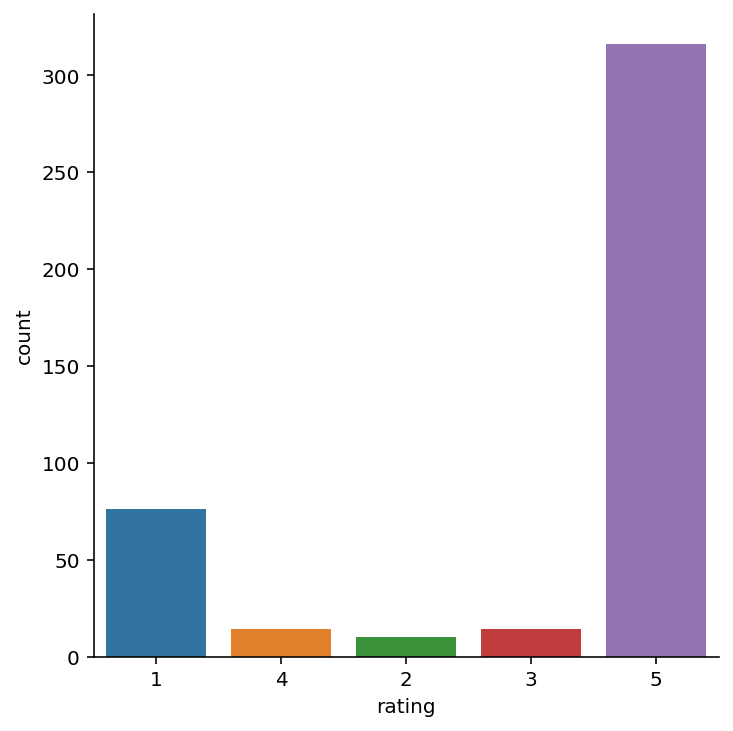

In [ ]:
sns.factorplot('rating',kind='count',data=df)

In [ ]:
df['rating'].value_counts()

5    316
1     76
4     14
3     14
2     10
Name: rating, dtype: int64

In [ ]:
high_rate_review = df[df['rating'] == '5']['review_text']
low_rate_review = df[df['rating'] <= '2']['review_text']

In [ ]:
len(high_rate_review)

316

In [ ]:
len(low_rate_review)

86

In [ ]:
low_rate_review[:10]

0      약 배달되는곳은 심히 한정적이고 약 택배배송은 만 하루째 제조중에 허위 송장 날려주...
4      약 배달되는곳은 심히 한정적이고 약 택배배송은 만 하루째 제조중에 허위 송장 날려주...
363                         급할때 이 앱쓰면 망함.. 스트레스만 더받음ㅋㅋㅋㅋ
368    비아그라, 수면제 같은거 여기서 여러 병원에서 받아서 그냥 당근에 팔아뿌도 되겠네 ...
3      집앞으로 처방전보내서 잘 받았네요. 단점이 약국에서 배달까지는 생각을 안하고 집단거...
7      집앞으로 처방전보내서 잘 받았네요. 단점이 약국에서 배달까지는 생각을 안하고 집단거...
96                        업데이트가 필요하다고 뜨는데, 업데이트가 안 되는데요?
6      처음 사용할땐 너무 편리햇는데 한달만에 돌아와보니 불편한게 많네요. 1. 배달약국 ...
2      처음 사용할땐 너무 편리햇는데 한달만에 돌아와보니 불편한게 많네요. 1. 배달약국 ...
377                                          쓰레기같은 앱이네요.
Name: review_text, dtype: object

In [ ]:
high_rate_review = high_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))
low_rate_review = low_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))

In [ ]:
high_rate_review[:10]

424                                                  좋아요
258                                  대박이네요 약 배달이 되는 시대네요
345                                  와 이런 서비스가 있다니 대박이네요
239                        급하게 필요한 약이 있어서 사용해 봤는데 대만족입니다
262                             앱 처음 이용하는데 편리하고 쉽게 이용했어요
169                  급할 때 앱으로 진료도 보고 약도 구매할 수 있다니 너무 편해요
8      자가격리중 아플때 아주 유용한 어플입니다 자가격리 1주일 남겨두고 편도염때문에 고열...
240            이런 서비스가 있는지 몰랐어요 아이들 많은 집이라 자주 이용할 것 같습니다
197                      진료도 빠르고 약 배달도 무료라서 자주 이용하고 있습니다
334                             다른 거 쓰다가 너무 하는데 너무 만족합니다
Name: review_text, dtype: object

In [ ]:
low_rate_review[:10]

0      약 배달되는곳은 심히 한정적이고 약 택배배송은 만 하루째 제조중에 허위 송장 날려주...
4      약 배달되는곳은 심히 한정적이고 약 택배배송은 만 하루째 제조중에 허위 송장 날려주...
363                               급할때 이 앱쓰면 망함 스트레스만 더받음
368    비아그라 수면제 같은거 여기서 여러 병원에서 받아서 그냥 당근에 팔아뿌도 되겠네 지...
3      집앞으로 처방전보내서 잘 받았네요 단점이 약국에서 배달까지는 생각을 안하고 집단거부...
7      집앞으로 처방전보내서 잘 받았네요 단점이 약국에서 배달까지는 생각을 안하고 집단거부...
96                          업데이트가 필요하다고 뜨는데 업데이트가 안 되는데요
6      처음 사용할땐 너무 편리햇는데 한달만에 돌아와보니 불편한게 많네요 1 배달약국 자동...
2      처음 사용할땐 너무 편리햇는데 한달만에 돌아와보니 불편한게 많네요 1 배달약국 자동...
377                                           쓰레기같은 앱이네요
Name: review_text, dtype: object

### 자연어 처리
- 단어 word count 정도만 체크
- 리뷰라 없을 것 같지만 1단어만 작성한 것은 제외

In [ ]:
low_tagger = Twitter()
high_tagger = Twitter()

In [ ]:
def get_word_low_rating(sentence):
    nouns = low_tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

def get_word_high_rating(sentence):
    nouns = high_tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

## 2점 이하의 word count

In [ ]:
low_countvector = CountVectorizer(tokenizer=get_word_low_rating, max_features=300)
low_tdf = low_countvector.fit_transform(low_rate_review)
low_words = low_countvector.get_feature_names()

In [ ]:
low_words[:5]

['가능', '가능성', '가요', '가입', '개선']

In [ ]:
count_mat = low_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
low_rating_word_count = list(zip(low_words, count))
low_rating_word_count = sorted(low_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
low_rating_word_count[:15]

[('약국', 60),
 ('배달', 41),
 ('진료', 36),
 ('병원', 32),
 ('처방전', 28),
 ('팩스', 23),
 ('어플', 15),
 ('약사', 13),
 ('처방', 13),
 ('확인', 13),
 ('의사', 12),
 ('전화', 11),
 ('불법', 10),
 ('사용', 9),
 ('리뷰', 8)]

## 5점 평점의 word count

In [ ]:
high_countvector = CountVectorizer(tokenizer=get_word_high_rating, max_features=300)
high_tdf = high_countvector.fit_transform(high_rate_review)
high_words = high_countvector.get_feature_names()

count_mat = high_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
high_rating_word_count = list(zip(high_words, count))
high_rating_word_count = sorted(high_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
high_rating_word_count[:15]

[('진료', 192),
 ('병원', 102),
 ('배달', 80),
 ('이용', 66),
 ('비대', 49),
 ('정말', 43),
 ('요즘', 41),
 ('대면', 40),
 ('서비스', 38),
 ('약국', 36),
 ('코로나', 35),
 ('어플', 33),
 ('가기', 32),
 ('진짜', 31),
 ('사용', 30)]

## WordCloud 그리기

In [ ]:
low_rating_document = low_rate_review.values
high_rating_document = high_rate_review.values

## 5점의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

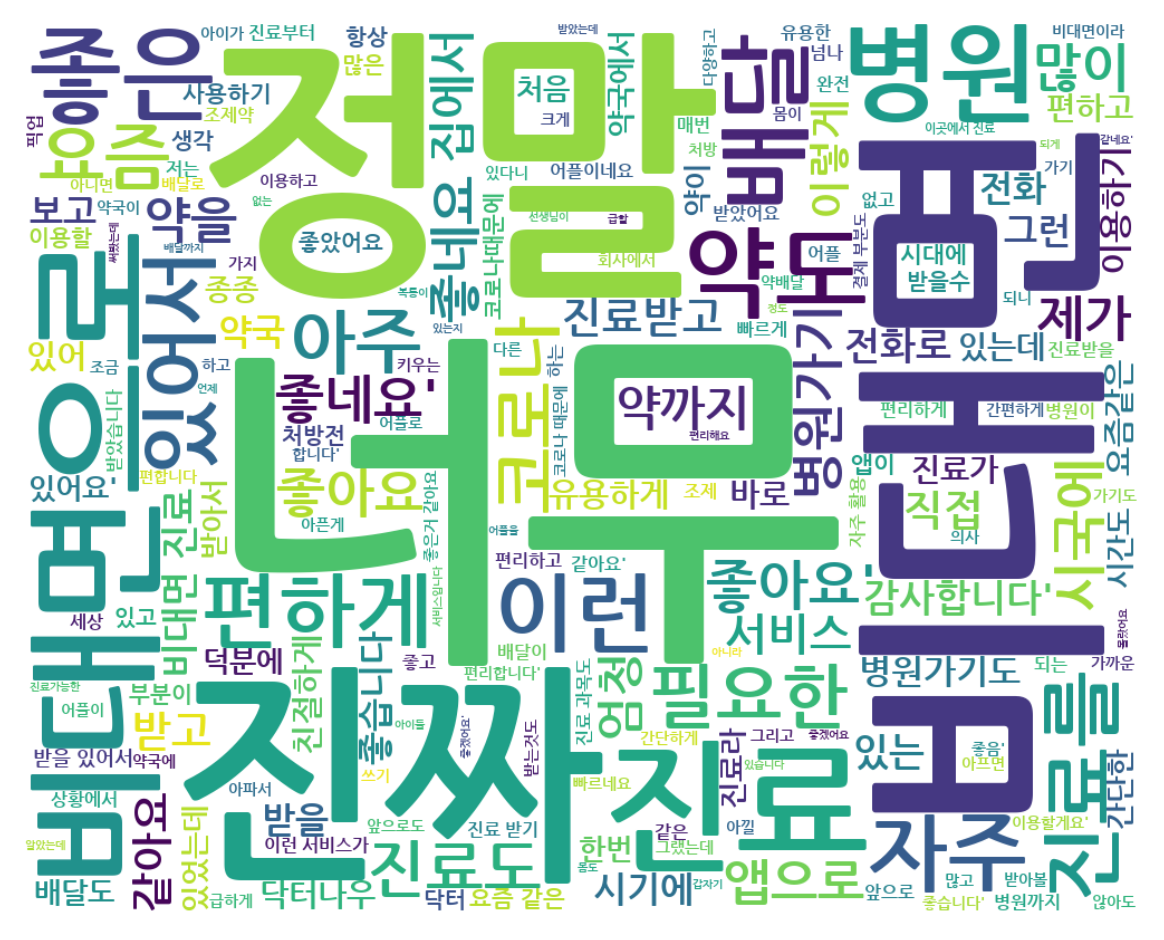

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(high_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2점 이하의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

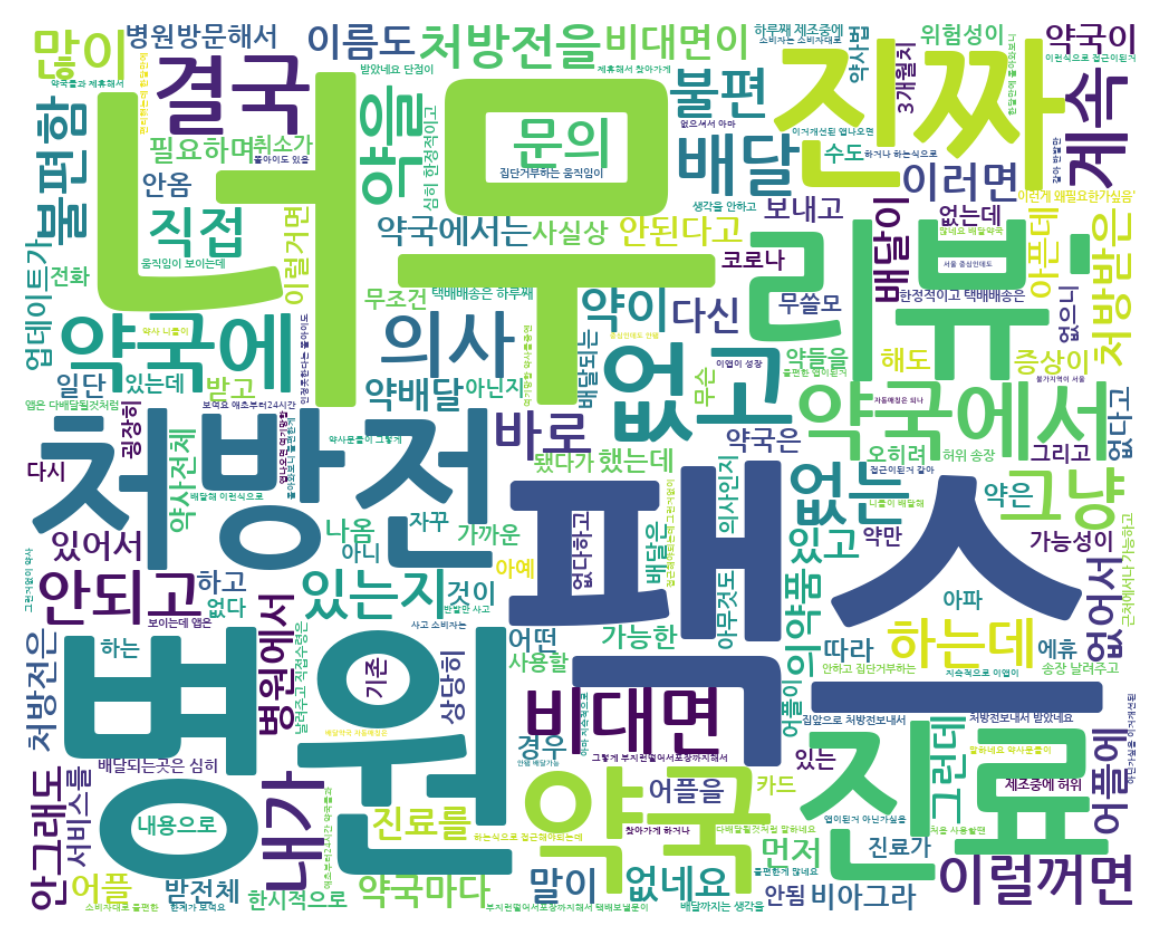

In [ ]:
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(low_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#닥터히어

In [ ]:
df = pd.read_json("/content/drive/MyDrive/puzzleAI/스토어 앱리뷰 분석/doctor_here_gp_review.json")

In [ ]:
df.head(3)

,body
0,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."
1,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."
2,"<div class=""d15Mdf bAhLNe""><div class=""xKpxId ..."


In [ ]:
p = re.compile(r'\d+')
def parser(body):
    bs = BeautifulSoup(body, 'html.parser')
    user_name = bs.find('span', class_='X43Kjb').text
    date = bs.find('span', class_='p2TkOb').text
    rating = bs.find('div', {'role':'img'})['aria-label']
    rating = p.findall(rating)[-1]
    review_text = bs.find('span', {'jsname':'bN97Pc'}).text
    return user_name, date, rating, review_text

In [ ]:
%%time
df['user_name'], df['date'], df['rating'], df['review_text'] = zip(*df['body'].map(parser))

CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 188 ms


In [ ]:
del df["body"]

In [ ]:
df.head(3)

,user_name,date,rating,review_text
0,Ella,2021년 7월 12일,1,자꾸 자동으로 어플이 종료됨. 가입하고 멤버십등록도 했는데 마이페이지 들어가면 자동...
1,Lily Park,2021년 3월 13일,1,년 맴버피가 $119 이라고요?? 저는 $199 냈는데... 기분 묘하네요 가입한지...
2,sehwan park,2021년 6월 2일,5,필요한 부분만 병원에 가지 않고 원격진료를 받을 수 있어서 너무 좋습니다. 앞으로도...


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y년 %m월 %d일')

In [ ]:
df = df.sort_values(by='date', ascending=False).reindex()

In [ ]:
print("최소 :", min(df['date'].value_counts().index))
print("최대 :", max(df['date'].value_counts().index))

최소 : 2020-03-05 00:00:00
최대 : 2021-07-12 00:00:00


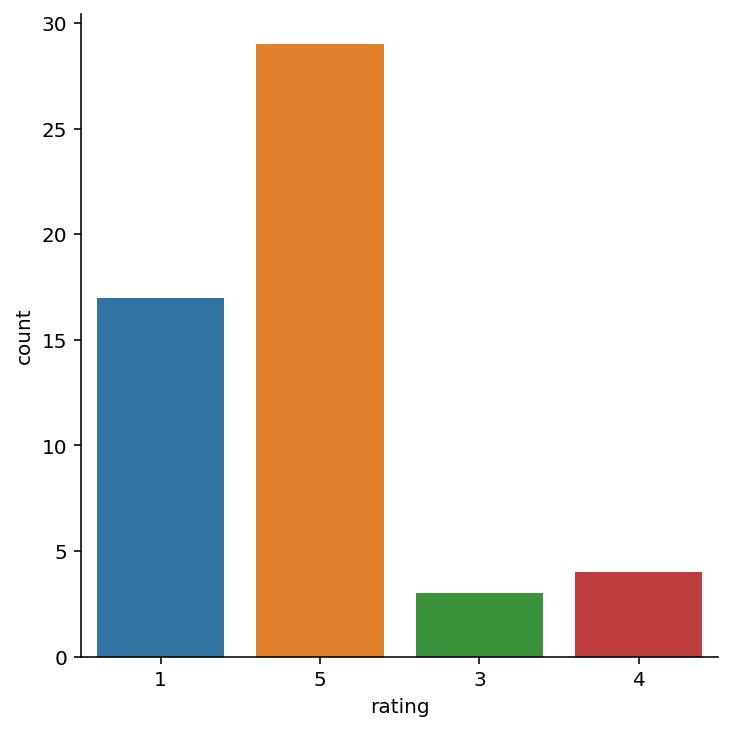

In [ ]:
sns.factorplot('rating',kind='count',data=df)

In [ ]:
df['rating'].value_counts()

5    29
1    17
4     4
3     3
Name: rating, dtype: int64

In [ ]:
high_rate_review = df[df['rating'] == '5']['review_text']
low_rate_review = df[df['rating'] <= '2']['review_text']

In [ ]:
len(high_rate_review)

29

In [ ]:
len(low_rate_review)

17

In [ ]:
low_rate_review[:10]

0     자꾸 자동으로 어플이 종료됨. 가입하고 멤버십등록도 했는데 마이페이지 들어가면 자동...
4     자꾸 자동으로 어플이 종료됨. 가입하고 멤버십등록도 했는데 마이페이지 들어가면 자동...
33                             저기.... 제발 광고좀 적게 나왔으면...
12    경찰에 신고하기전에 빨리 탈퇴처리해주세요..지금당장 탈퇴안시켜주면 세금탈세도 신고할...
3                              불면증관련 약 (수면제)도 처방받을수있나요?
7                              불면증관련 약 (수면제)도 처방받을수있나요?
5     년 맴버피가 $119 이라고요?? 저는 $199 냈는데... 기분 묘하네요 가입한지...
1     년 맴버피가 $119 이라고요?? 저는 $199 냈는데... 기분 묘하네요 가입한지...
26       진료취소해준다그랬는데 결제되고 다시 접수하려니 업무시간아니라뜨고 앱진짜이상하네요ㅡㅡ
18    월결제를 했는데 왜 진료비가 또 결제된거죠? 앱에 나와있는 문의전화는 아무리해도 연...
Name: review_text, dtype: object

In [ ]:
high_rate_review = high_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))
low_rate_review = low_rate_review.apply(lambda x:re.sub('[^가-힣\s\d]',"",x))

In [ ]:
high_rate_review[:10]

2     필요한 부분만 병원에 가지 않고 원격진료를 받을 수 있어서 너무 좋습니다 앞으로도 ...
6     필요한 부분만 병원에 가지 않고 원격진료를 받을 수 있어서 너무 좋습니다 앞으로도 ...
31             편리해요 미국에서 병원가기 무서웠는데 추가 비용이 없다고 해서 가입했어요
30    돈도 아끼고 시간도 아무때나 골라서 진료를 받을 수 있다는 점만 해도 너무 좋은데 ...
52     한국 처방전으로 미국 약국에서 약을 탈 수 있나요 영문으로 된 처방전을 발급해 주시나요
42                               감사합니다 의사선생님 원격진료 신세계네요
45                                         원격진료 너무 편하네요
46                              원격의료 너무좋습니다 반대인간들 쓰레기인듯
44                           친절하게 상담해주신 이재혁 원장님 감사드립니다 
8     해외에 거주하는 한인으로서 너무 감사드립니다 항상 현지 의사들에게 증세 설명할 때 ...
Name: review_text, dtype: object

In [ ]:
low_rate_review[:10]

0     자꾸 자동으로 어플이 종료됨 가입하고 멤버십등록도 했는데 마이페이지 들어가면 자동으...
4     자꾸 자동으로 어플이 종료됨 가입하고 멤버십등록도 했는데 마이페이지 들어가면 자동으...
33                                    저기 제발 광고좀 적게 나왔으면
12    경찰에 신고하기전에 빨리 탈퇴처리해주세요지금당장 탈퇴안시켜주면 세금탈세도 신고할 계...
3                                 불면증관련 약 수면제도 처방받을수있나요
7                                 불면증관련 약 수면제도 처방받을수있나요
5     년 맴버피가 119 이라고요 저는 199 냈는데 기분 묘하네요 가입한지 2주되었는데...
1     년 맴버피가 119 이라고요 저는 199 냈는데 기분 묘하네요 가입한지 2주되었는데...
26         진료취소해준다그랬는데 결제되고 다시 접수하려니 업무시간아니라뜨고 앱진짜이상하네요
18    월결제를 했는데 왜 진료비가 또 결제된거죠 앱에 나와있는 문의전화는 아무리해도 연결...
Name: review_text, dtype: object

### 자연어 처리
- 단어 word count 정도만 체크
- 리뷰라 없을 것 같지만 1단어만 작성한 것은 제외

In [ ]:
low_tagger = Twitter()
high_tagger = Twitter()

In [ ]:
def get_word_low_rating(sentence):
    nouns = low_tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

def get_word_high_rating(sentence):
    nouns = high_tagger.nouns(sentence)
    return [noun for noun in nouns if len(noun) > 1]

## 2점 이하의 word count

In [ ]:
low_countvector = CountVectorizer(tokenizer=get_word_low_rating, max_features=300)
low_tdf = low_countvector.fit_transform(low_rate_review)
low_words = low_countvector.get_feature_names()

In [ ]:
low_words[:5]

['가입', '개선', '개인', '걱정', '건강']

In [ ]:
count_mat = low_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
low_rating_word_count = list(zip(low_words, count))
low_rating_word_count = sorted(low_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
low_rating_word_count[:15]

[('진료', 7),
 ('자동', 6),
 ('종료', 6),
 ('가입', 5),
 ('어플', 5),
 ('격진', 4),
 ('결제', 3),
 ('기분', 3),
 ('등록', 3),
 ('사용', 3),
 ('처방', 3),
 ('카드', 3),
 ('환불', 3),
 ('관련', 2),
 ('기간', 2)]

## 5점 평점의 word count

In [ ]:
high_countvector = CountVectorizer(tokenizer=get_word_high_rating, max_features=300)
high_tdf = high_countvector.fit_transform(high_rate_review)
high_words = high_countvector.get_feature_names()

count_mat = high_tdf.sum(axis=0)
count = np.squeeze(np.asarray(count_mat))
high_rating_word_count = list(zip(high_words, count))
high_rating_word_count = sorted(high_rating_word_count, key=lambda t:t[1], reverse=True)

In [ ]:
high_rating_word_count[:15]

[('격진', 9),
 ('병원', 9),
 ('의사', 8),
 ('진료', 7),
 ('선생님', 5),
 ('기대', 4),
 ('도움', 4),
 ('시간', 4),
 ('널리', 3),
 ('서비스', 3),
 ('이용', 3),
 ('자주', 3),
 ('정말', 3),
 ('코로나', 3),
 ('해외', 3)]

## WordCloud 그리기

In [ ]:
low_rating_document = low_rate_review.values
high_rating_document = high_rate_review.values

## 5점의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

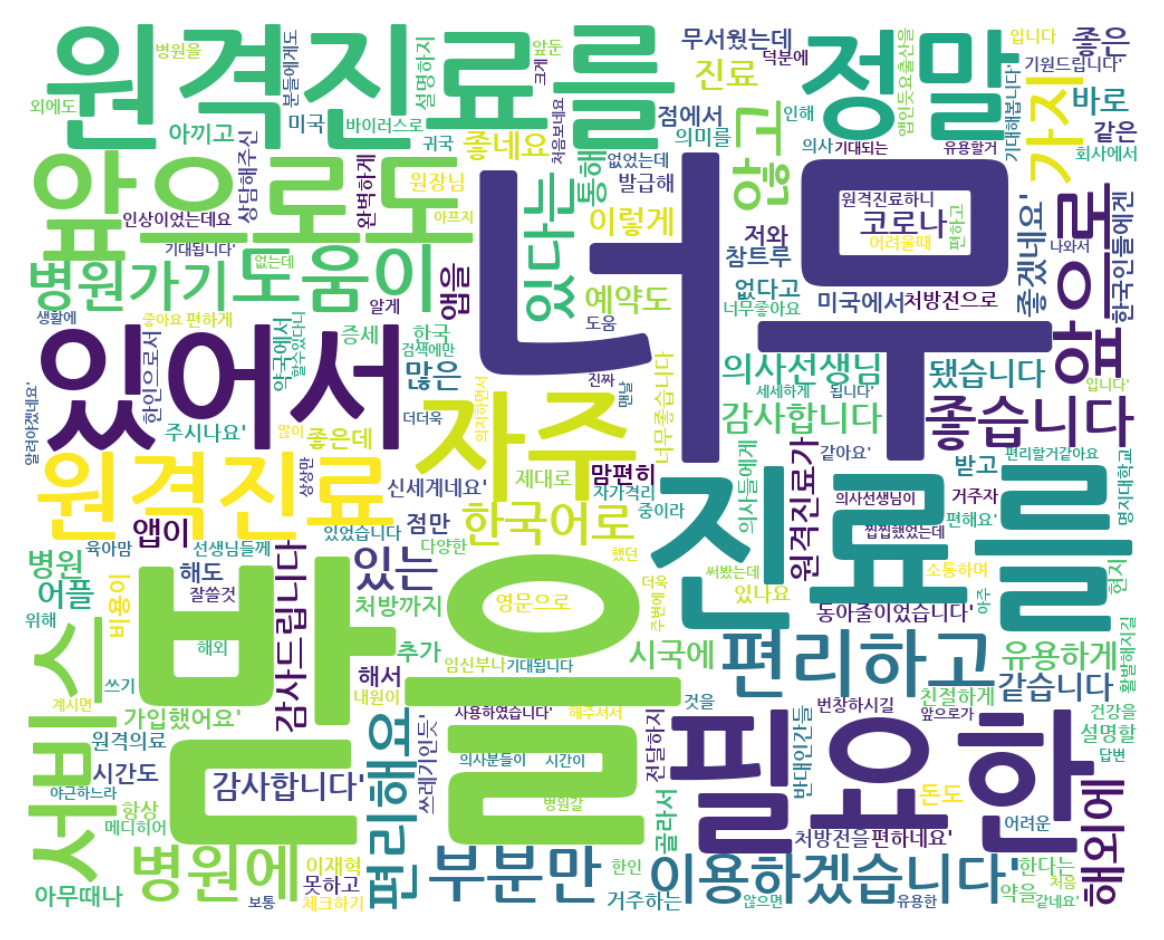

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(high_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2점 이하의 Word Cloud
- 단, 형용사나 명사만 체크하진 않고.. 단순한 word count
- 디벨롭할 수 있는 부분

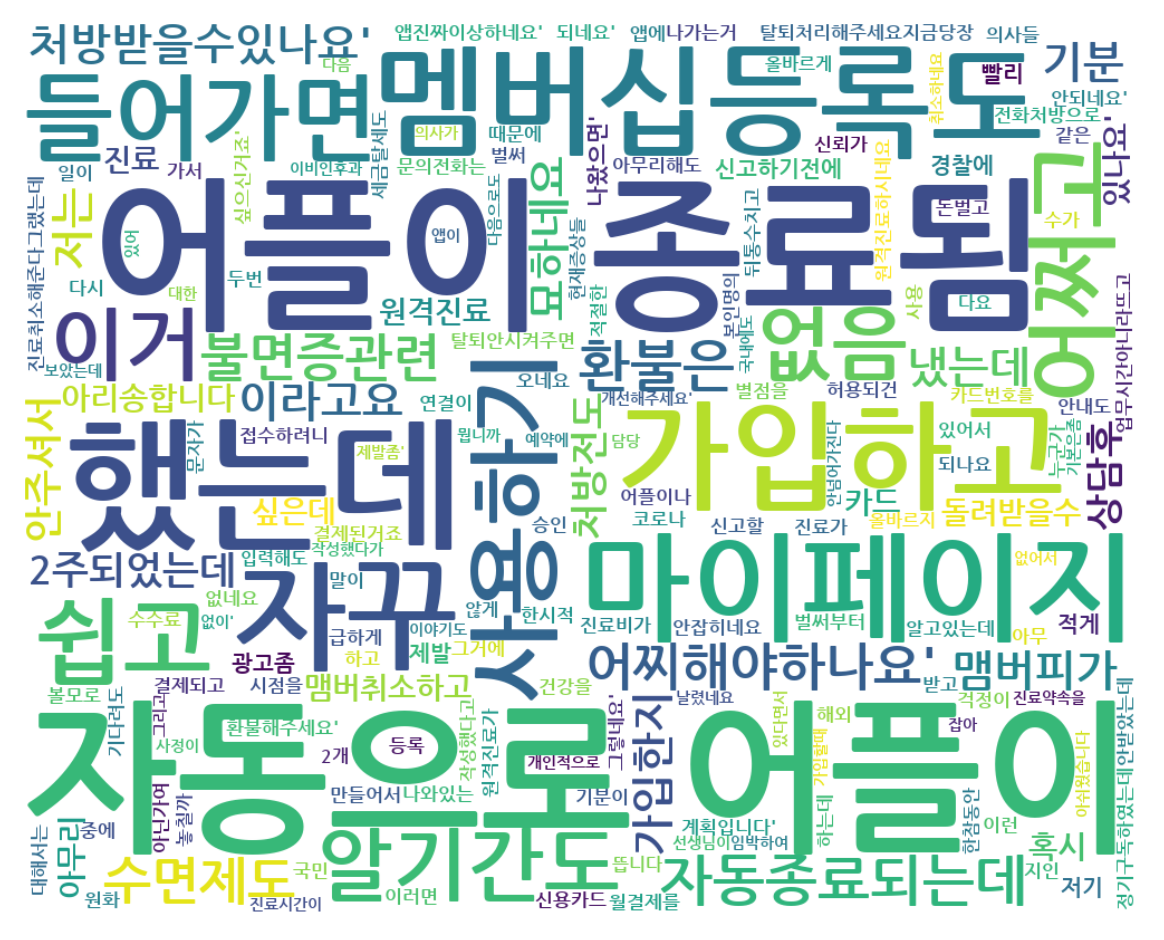

In [ ]:
wc = WordCloud(width = 1000, height = 800, background_color="white", font_path=font_path).generate(np.array2string(low_rating_document))
plt.figure(figsize=(6, 5), dpi=120)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()